#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Требуется:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#DecisionTree-регрессия" data-toc-modified-id="DecisionTree-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTree регрессия</a></span></li><li><span><a href="#CatBoost-регрессия" data-toc-modified-id="CatBoost-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost регрессия</a></span></li><li><span><a href="#LGBM-регрессия" data-toc-modified-id="LGBM-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBM регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Прочитал,-понял-ваши-комментарии,-я-чуть-отстал-от-курса,-а-когорту-менять-не-хочется,-в-данном-случае-хотелось-бы-продолжить-обучение" data-toc-modified-id="Прочитал,-понял-ваши-комментарии,-я-чуть-отстал-от-курса,-а-когорту-менять-не-хочется,-в-данном-случае-хотелось-бы-продолжить-обучение-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Прочитал, понял ваши комментарии, я чуть отстал от курса, а когорту менять не хочется, в данном случае хотелось бы продолжить обучение</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

загрузим и изучим данные

In [2]:
data_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data_taxi.sort_index(inplace=True)
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


По данным видим, что у нас есть информмация с 1 марта 2018 года, по 31 августа 2018 года.

## Анализ

<AxesSubplot:xlabel='datetime'>

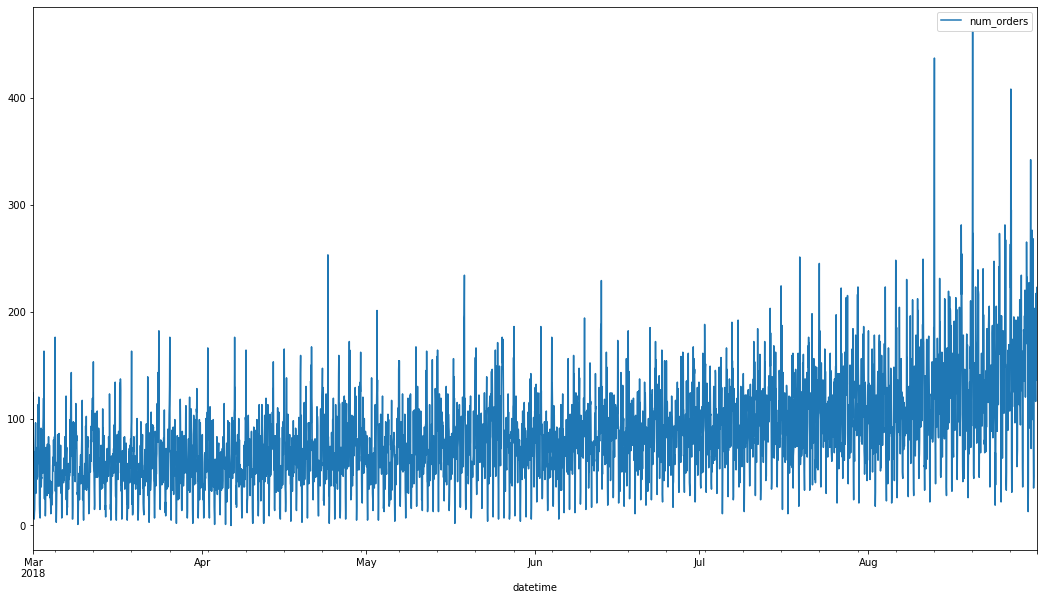

In [3]:
# Построим график с разбивкой по часу
data_taxi = data_taxi .resample('1H').sum()
figsize = (18,10)
data_taxi.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

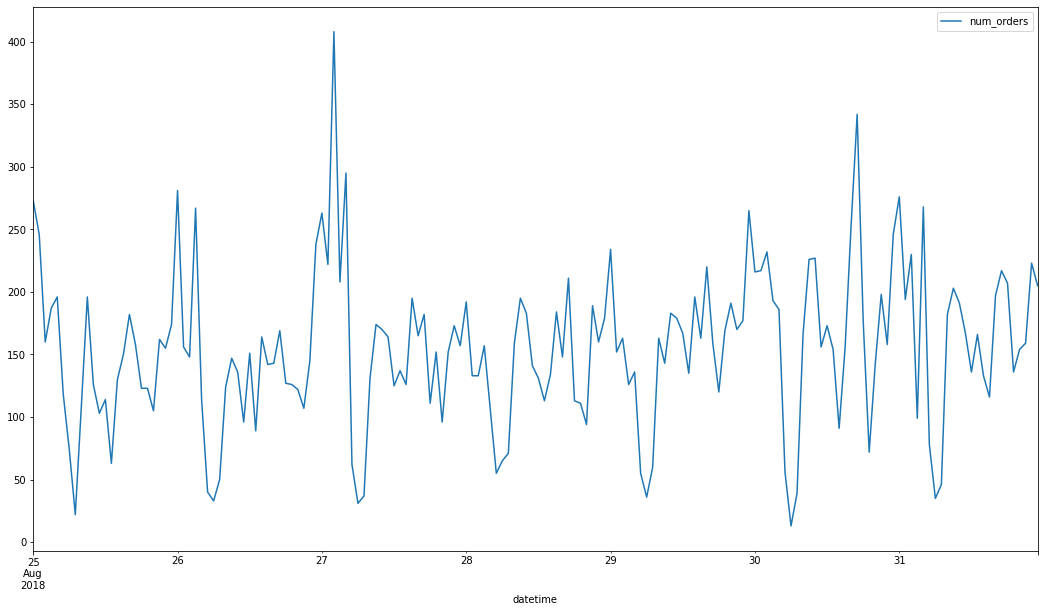

In [4]:
data_taxi['2018-08-25':'2018-08-31'].plot(figsize=figsize)

Смотрим график за неделю, потому что по прошлому графику видим повторы пиков, сезонность

<AxesSubplot:xlabel='datetime'>

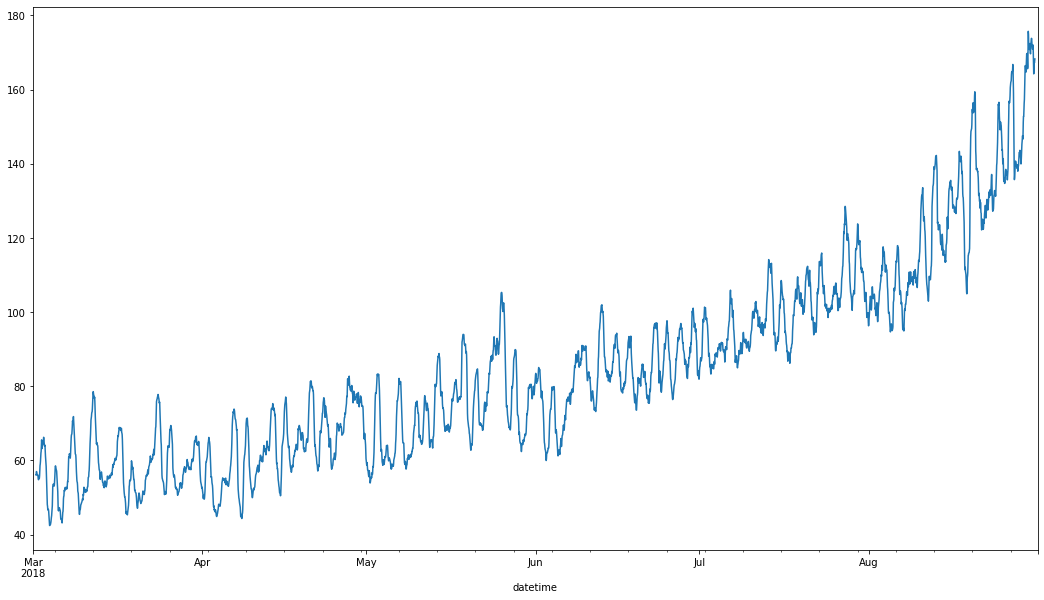

In [5]:
# Рассмотрим тернды, сезонность, остаток декомпозиции заказа такси
decomposed_data_taxi = seasonal_decompose(data_taxi)
decomposed_data_taxi.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

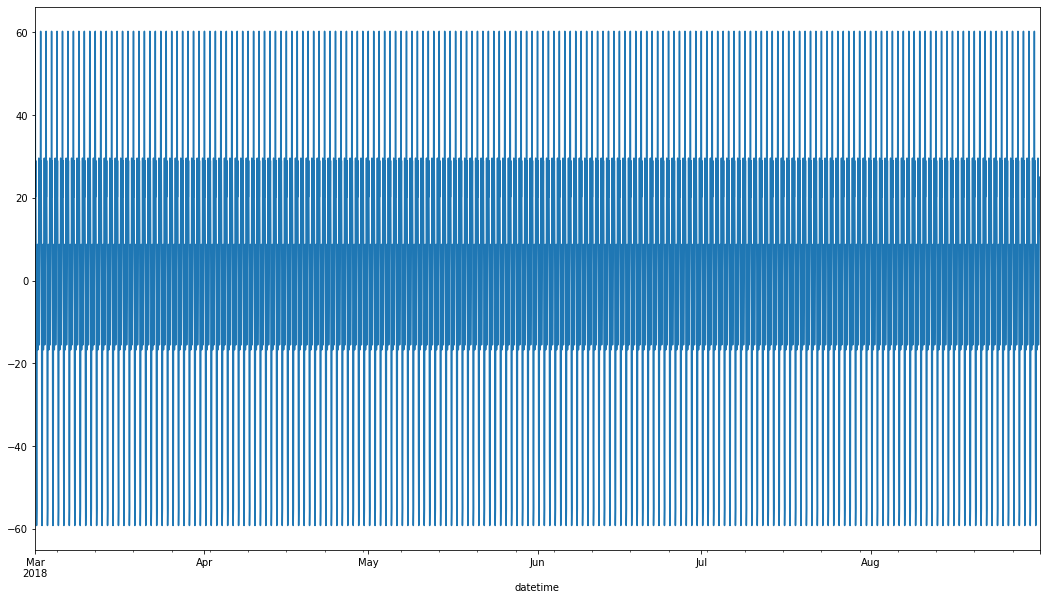

In [6]:
decomposed_data_taxi.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

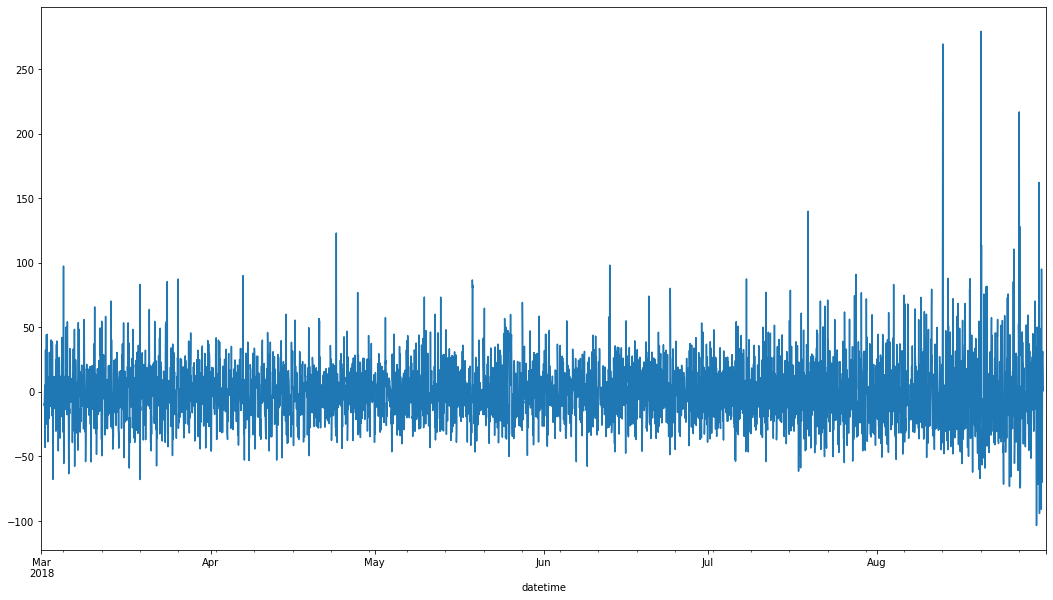

In [7]:
decomposed_data_taxi.resid.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

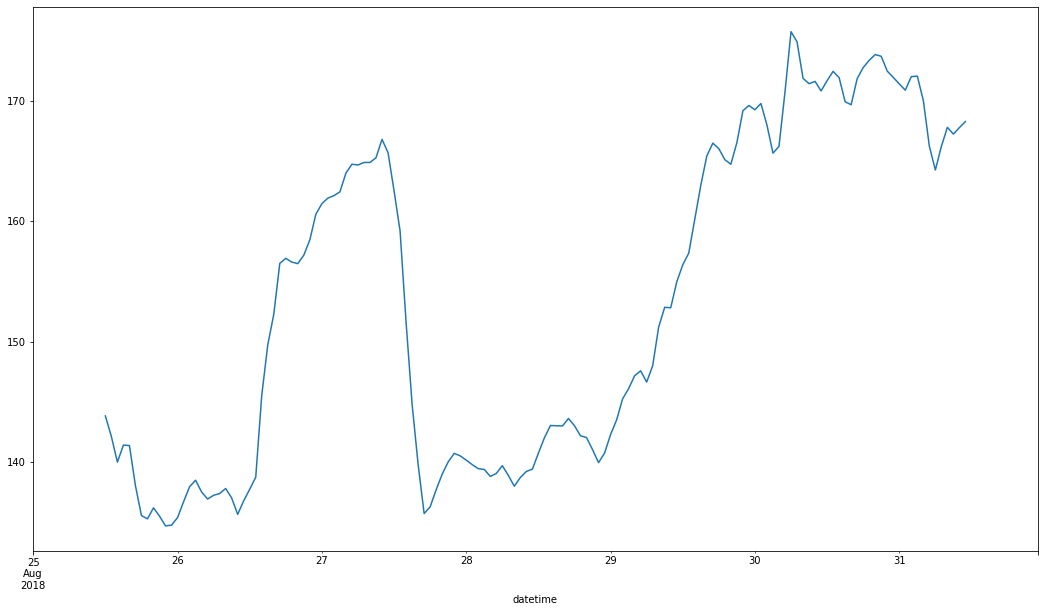

In [8]:
# Рассмотрим тернды, сезонность, остаток декомпозиции заказа такси
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
decomposed_data_taxi.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

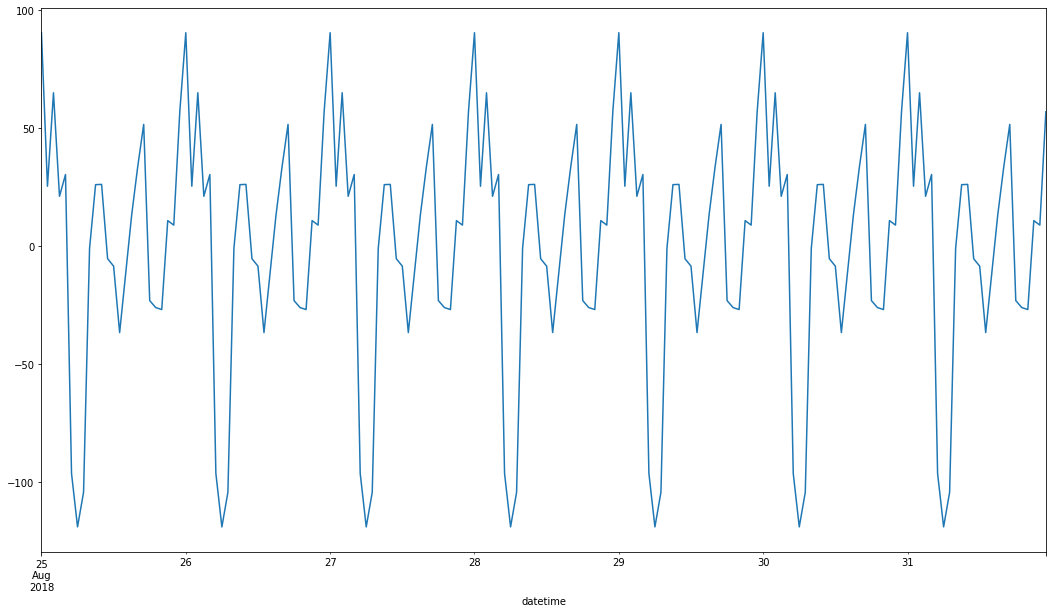

In [9]:
decomposed_data_taxi.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

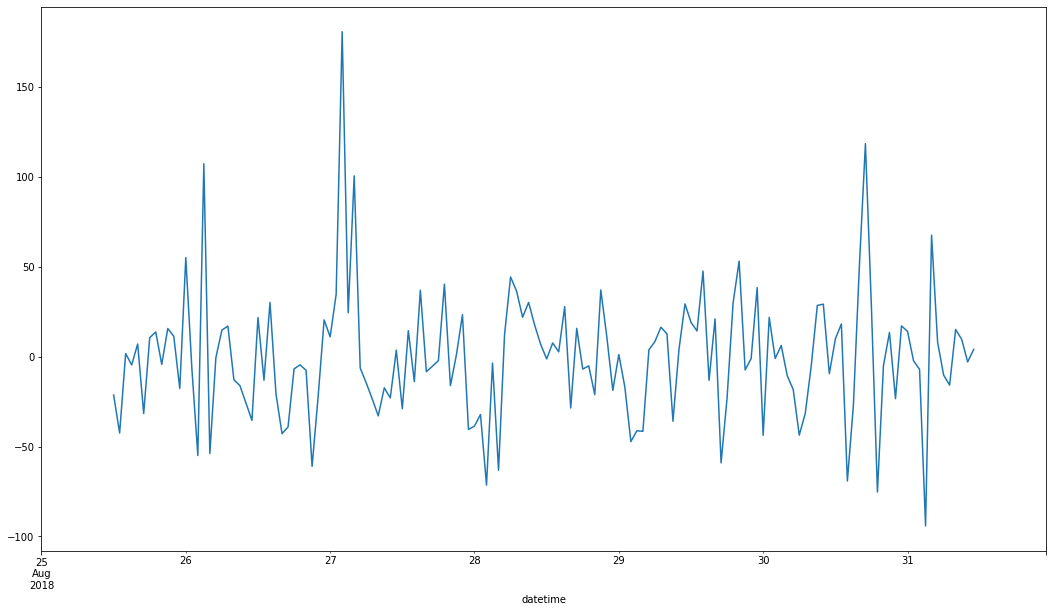

In [10]:
decomposed_data_taxi.resid.plot(figsize=figsize)

**Вывод**

- Дисперсия увеличичвается
- Тренд в общем растет, то есть кол-во заказов и пользователей растет
- Видно что в раннее утро кол-во заказов резко падает
- Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени.

<AxesSubplot:xlabel='datetime'>

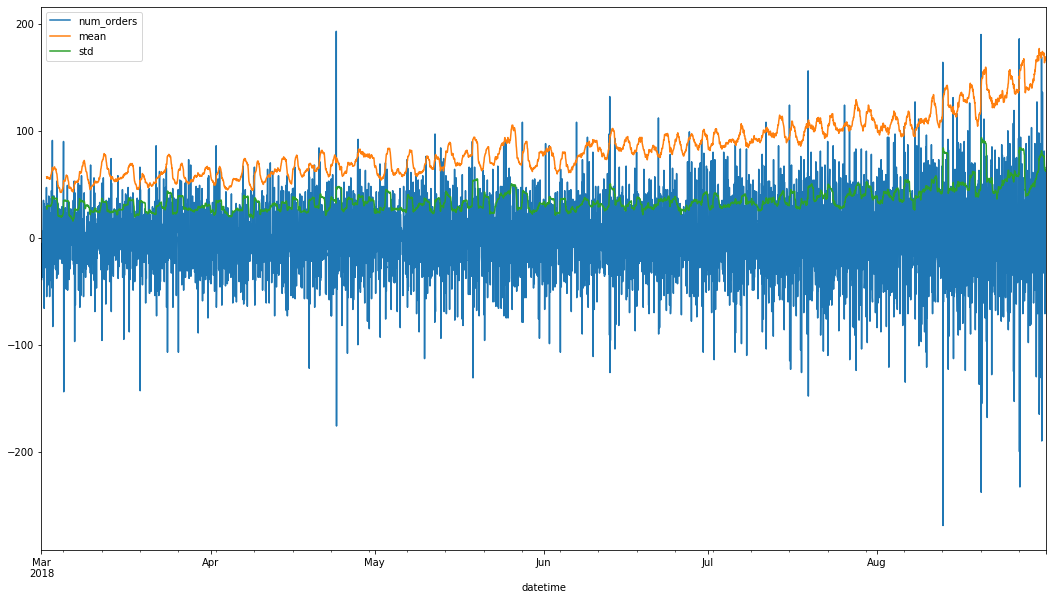

In [11]:
taxi_shift = data_taxi - data_taxi.shift()
taxi_shift['mean'] = data_taxi['num_orders'].rolling(24).mean()
taxi_shift['std'] = data_taxi['num_orders'].rolling(24).std()
taxi_shift.plot(figsize=figsize)

Необходимые нам признаки:
- day так как видно ежедневная сезонность
- month (по графику сезонности)
- dayofweak (по графику остатков)

lag примем как 24 часа

rolling_mean примем как сутки то есть 48 часа

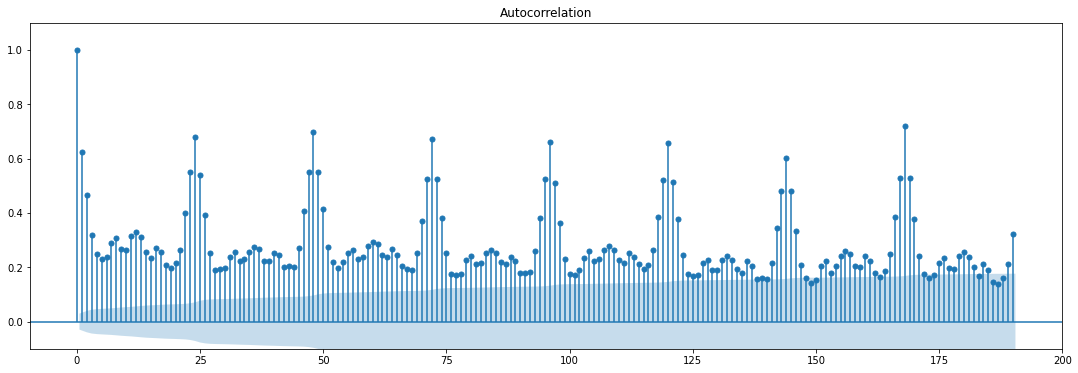

In [23]:
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [12]:
# Создадим признаки для обучения модели
max_lag = 48
rolling_mean_size = 24
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [13]:
data_taxi_copy = data_taxi.copy()

make_features(data_taxi,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1, random_state=1515)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Обучение

### Линейная регрессия

In [14]:
%%time
tscv = TimeSeriesSplit(n_splits=8)
regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 24.55091540638874
CPU times: user 696 ms, sys: 1.99 s, total: 2.68 s
Wall time: 2.62 s


In [15]:
%%time

# С масштабированием
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 23.83075800330959
CPU times: user 456 ms, sys: 1 s, total: 1.46 s
Wall time: 1.41 s


### DecisionTree регрессия

In [16]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}

Grid scores on development set:

30.353002 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
28.234262 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
27.944294 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
27.364693 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
27.927048 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
28.481639 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
29.202782 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
30.652127 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}
31.654743 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 1515}
31.991780 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 1515}
32.560509 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 1515}

### CatBoost регрессия

In [17]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[1515],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}

Grid scores on development set:

22.915099 for {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
23.553109 for {'learning_rate': 0.2, 'random_state': 1515, 'verbose': False}
23.854358 for {'learning_rate': 0.3, 'random_state': 1515, 'verbose': False}

CPU times: user 3min 31s, sys: 2.12 s, total: 3min 33s
Wall time: 3min 56s


In [18]:
%%time

regressor = CatBoostRegressor(learning_rate=0.1,
                              iterations = 500,
                              random_state=1515, 
                              verbose=False, 
                              ) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 22.837787609639143
CPU times: user 32.5 s, sys: 324 ms, total: 32.8 s
Wall time: 39 s


### LGBM регрессия

In [19]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 1515}

Grid scores on development set:

23.186290 for {'learning_rate': 0.1, 'random_state': 1515}
23.820639 for {'learning_rate': 0.2, 'random_state': 1515}
24.498188 for {'learning_rate': 0.3, 'random_state': 1515}
25.434456 for {'learning_rate': 0.4, 'random_state': 1515}
26.095656 for {'learning_rate': 0.5, 'random_state': 1515}

CPU times: user 8min 37s, sys: 4.76 s, total: 8min 41s
Wall time: 8min 45s


**Вывод** 
- Было использовано 4 регрессионных моделей. 
- Зафиксированы лучшие гиперпараметры и время их выполнения. 
- Catboost показал лучшие результаты

## Тестирование

CPU times: user 12.5 s, sys: 129 ms, total: 12.7 s
Wall time: 14.3 s


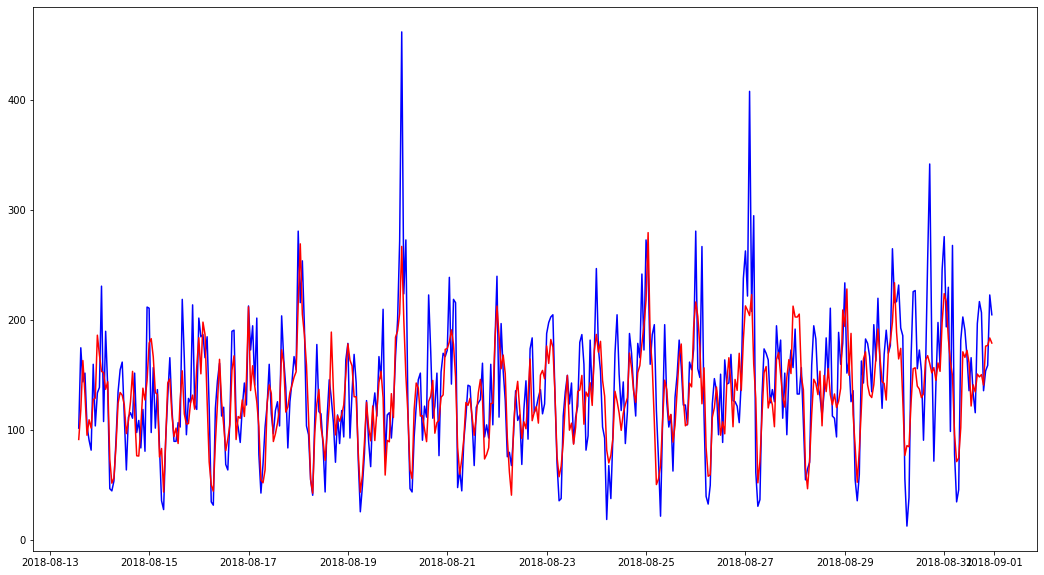

In [20]:
%%time

model = CatBoostRegressor(learning_rate=0.1, 
                          random_state=1515, 
                          verbose=False) 
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-')

In [21]:
final_RMSE_CBR

39.13105405615348

In [ ]:
Мы добились поставленной задачи с помощью CatBoost модели, она показала лучший RMSE результат